# Ejercicio para desarrollo de modelo de aprendizaje automático

## **Requisitos:**

- Obtener de la API de Open-Meteor la información de parámetros diarios: `"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "precipitation_hours", "wind_speed_10m_max", "shortwave_radiation_sum"]`
- Escoger un rango de fechas (de preferencia, dos años o más)
- Revisar que no existan campos duplicados, nulos.
- Escoger variable objetivo (lluvia, radiación, viento o temperatura)
- Hacer un análisis exploratorio (histogramas, gráficos de caja, matriz de correlación)
- Escalado de datos (MinMax, Standard)
- Implementar un algoritmo de aprendizaje (RandomForest u otro)
- Imprimir métricas resultantes de desempeño

### Importación de librerias

In [74]:
import requests  # Para realizar solicitudes HTTP
import pandas as pd  # Para manipulación de datos
import numpy as np  # Para operaciones numéricas
import matplotlib.pyplot as plt  # Para gráficos
import seaborn as sns  # Para visualización de datos
from sklearn.model_selection import train_test_split  # Para dividir datos en entrenamiento y prueba
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Para escalar datos
from sklearn.ensemble import RandomForestRegressor  # Modelo de aprendizaje automático
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Métricas de evaluación
# Entrenar el modelo RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### Extracción de datos de GitHub

In [21]:
url = "https://raw.githubusercontent.com/CirceDelLop/ClimaAcademiaDataEngineer/refs/heads/main/datosClimaticos_2025-02-07.csv"
df_clima = pd.read_csv(url)
df_clima.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,precipitation_hours,wind_speed_10m_max,shortwave_radiation_sum,year,month,day
0,2023-01-01,21.1,5.9,12.8,0.0,0.0,15.5,17.52,2023,1,1
1,2023-01-02,21.3,5.9,13.4,0.0,0.0,22.0,17.36,2023,1,2
2,2023-01-03,23.0,5.8,14.7,0.1,1.0,10.4,18.60,2023,1,3
3,2023-01-04,22.9,6.7,14.3,0.0,0.0,18.8,20.03,2023,1,4
4,2023-01-05,22.0,7.7,14.2,0.3,3.0,20.5,19.44,2023,1,5


### Renombrar columnas

In [22]:
df_clima.rename(columns={
    "time": "fecha",
    "temperature_2m_max": "temperaturaMaxima",
    "temperature_2m_min": "temperaturaMinima",
    "temperature_2m_mean":"temperaturaMedia",
    "rain_sum":"sumaLluvia",
    "precipitation_hours": "horasPrecipitacion",
    "wind_speed_10m_max": "velocidadViento",
    "shortwave_radiation_sum": "sumaRadiacionOndaCorta"
}, inplace=True)

### Análisis expliratorio

In [23]:
# Información del conjunto de datos
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fecha                   93 non-null     object 
 1   temperaturaMaxima       93 non-null     float64
 2   temperaturaMinima       93 non-null     float64
 3   temperaturaMedia        93 non-null     float64
 4   sumaLluvia              93 non-null     float64
 5   horasPrecipitacion      93 non-null     float64
 6   velocidadViento         93 non-null     float64
 7   sumaRadiacionOndaCorta  93 non-null     float64
 8   year                    93 non-null     int64  
 9   month                   93 non-null     int64  
 10  day                     93 non-null     int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 8.1+ KB


In [24]:
# Lista de columnas numéricas
numerical_columns = ["temperaturaMaxima", "temperaturaMinima", "sumaLluvia", "horasPrecipitacion", "velocidadViento","sumaRadiacionOndaCorta"]

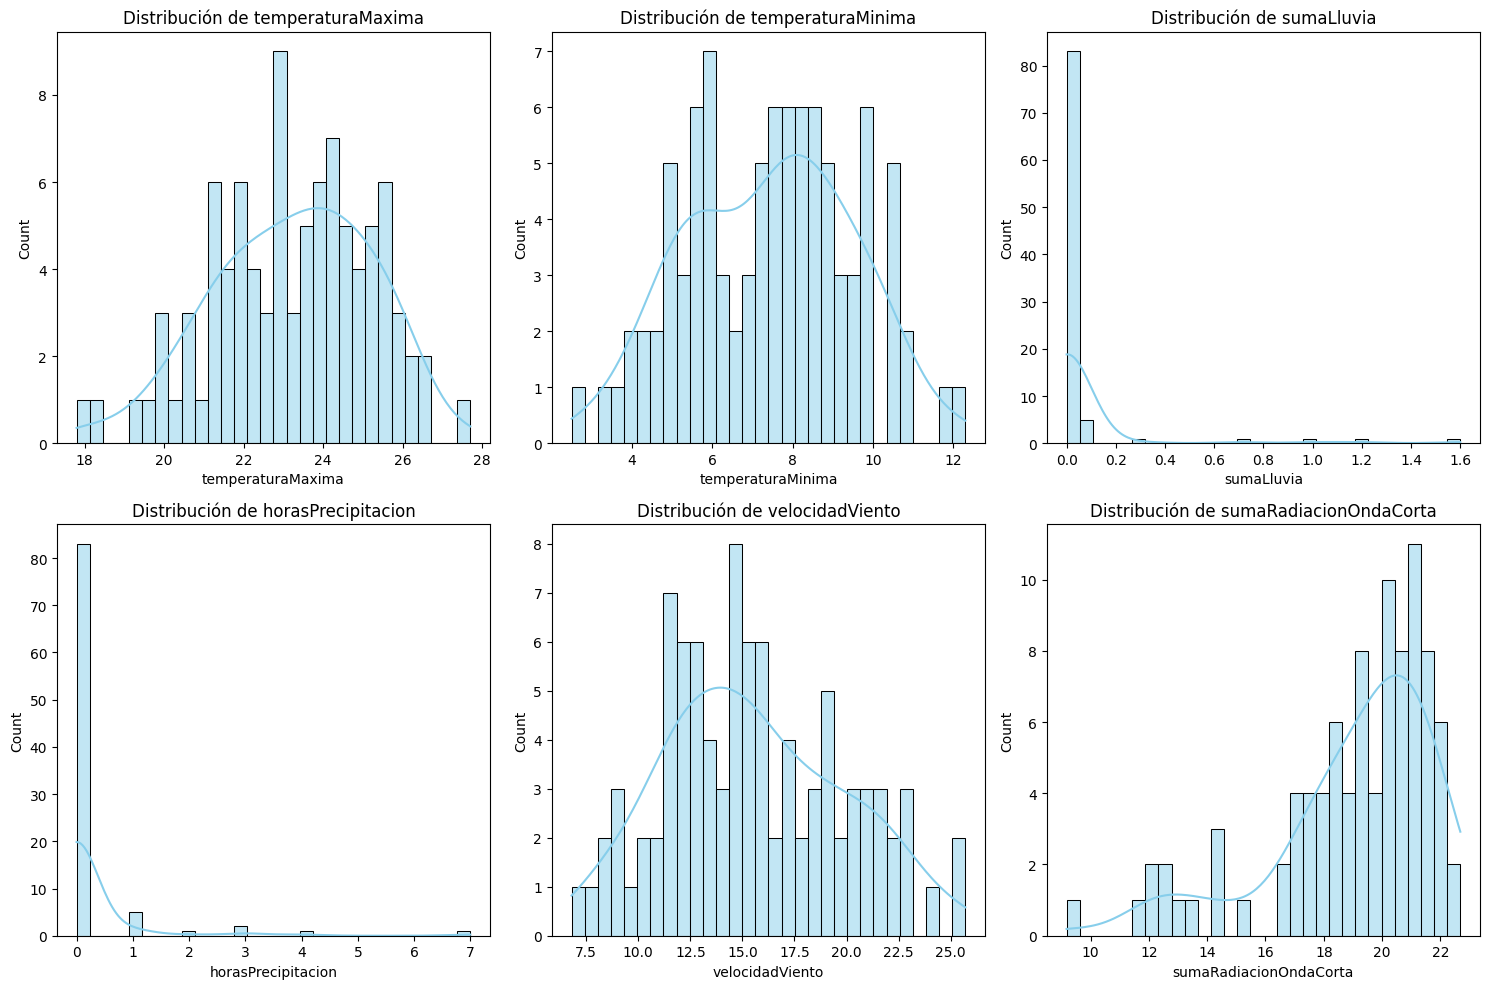

In [25]:
# Histograma
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_clima[col].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f'Distribución de {col}')

plt.tight_layout()
plt.show()

In [26]:
# Seleccionar solo las columnas numéricas
df_numericas = df_clima.select_dtypes(include=["number"]).drop(columns=["year", "month", "day"], errors="ignore")

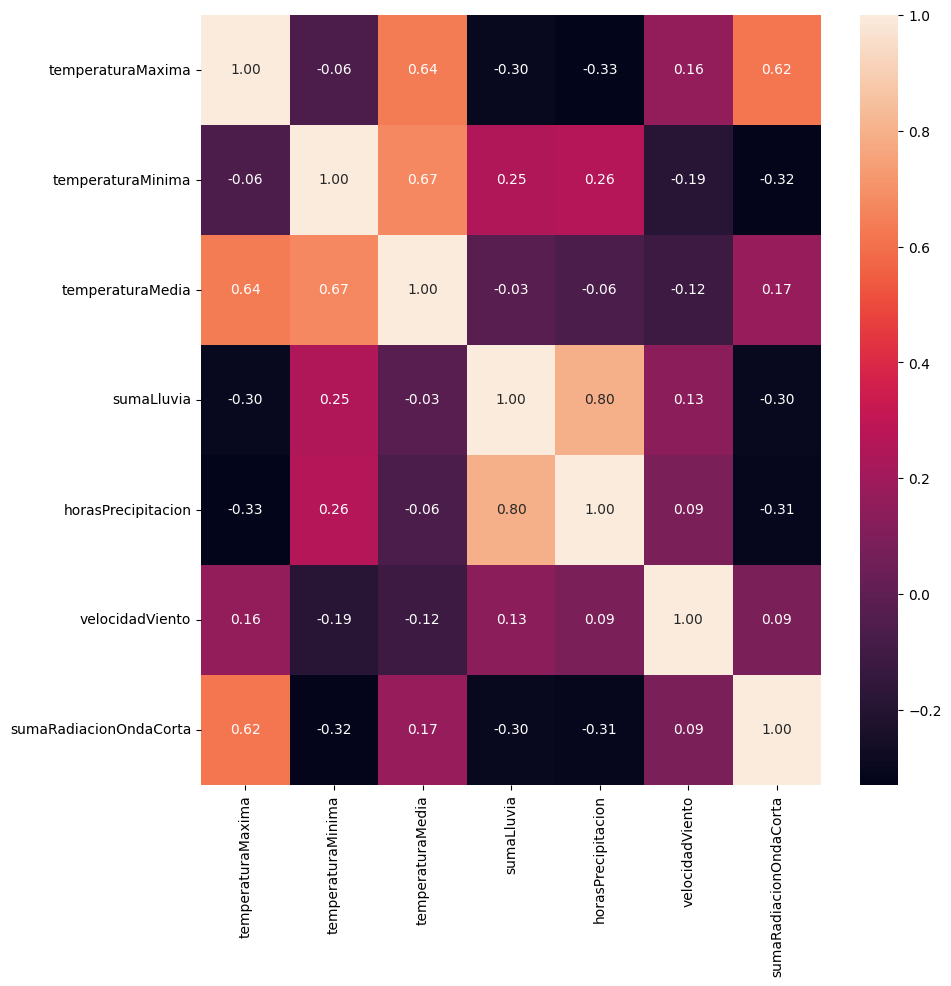

In [27]:
# Matriz de correlación
plt.figure(figsize=(10,10))
sns.heatmap(df_numericas.corr(), annot=True, fmt='.2f')
plt.show()

### Escalado de datos (MinMax, Standard)

In [39]:
# Lista de columnas numéricas
numerical_columns = ["temperaturaMaxima", "temperaturaMinima", "sumaLluvia", "horasPrecipitacion", "velocidadViento","sumaRadiacionOndaCorta"]

In [45]:
# Copia del dataset para la prueba de StandarScaler()
df_clima_ss = df_clima.copy()

# Implementación de StandarScaler sobre los datos numéricos
scaler_standar = StandardScaler()
df_clima_ss[numerical_columns] = scaler_standar.fit_transform(df_clima_ss[numerical_columns])

df_clima_ss.describe()

,temperaturaMaxima,temperaturaMinima,temperaturaMedia,sumaLluvia,horasPrecipitacion,velocidadViento,sumaRadiacionOndaCorta,year,month,day
count,9.300000e+01,9.300000e+01,93.000000,9.300000e+01,9.300000e+01,9.300000e+01,9.300000e+01,93.000000,93.0,93.000000
mean,1.206920e-15,1.323911e-15,14.802151,2.268198e-17,5.730183e-17,-2.283120e-16,5.204917e-16,2024.000000,1.0,16.000000
std,1.005420e+00,1.005420e+00,1.396889,1.005420e+00,1.005420e+00,1.005420e+00,1.005420e+00,0.820922,0.0,8.992751
min,-2.757429e+00,-2.394860e+00,11.300000,-2.380971e-01,-2.686642e-01,-2.037030e+00,-3.490883e+00,2023.000000,1.0,1.000000
25%,-6.750211e-01,-7.865831e-01,13.800000,-2.380971e-01,-2.686642e-01,-7.557452e-01,-3.556621e-01,2023.000000,1.0,8.000000
50%,3.604482e-02,9.065881e-02,14.700000,-2.380971e-01,-2.686642e-01,-1.267508e-01,3.248233e-01,2024.000000,1.0,16.000000
75%,7.471108e-01,7.242224e-01,15.800000,-2.380971e-01,-2.686642e-01,7.585007e-01,7.167259e-01,2025.000000,1.0,24.000000
max,2.270824e+00,2.381235e+00,17.800000,6.446590e+00,7.018852e+00,2.365931e+00,1.318831e+00,2025.000000,1.0,31.000000


In [40]:
#Crear una copia del DataFrame para escalado
df_clima_escalado=df_clima.copy()

In [46]:
# Aplicar el escalado a las columnas numéricas
# MinMaxScaler hace un escalado de valores por defecto entre 0 y 1.
scaler = MinMaxScaler()
df_clima_escalado[numerical_columns] = scaler.fit_transform(df_clima_escalado[numerical_columns])

In [47]:
#Mostrar una vista previa del DataFrame escalado
print("Primeras filas del DataFrame escalado:")
df_clima_escalado.describe()

Primeras filas del DataFrame escalado:


,temperaturaMaxima,temperaturaMinima,temperaturaMedia,sumaLluvia,horasPrecipitacion,velocidadViento,sumaRadiacionOndaCorta,year,month,day
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.0,93.000000
mean,0.548387,0.501426,14.802151,0.035618,0.036866,0.462650,0.725798,2024.000000,1.0,16.000000
std,0.199954,0.210511,1.396889,0.150406,0.137965,0.228351,0.209039,0.820922,0.0,8.992751
min,0.000000,0.000000,11.300000,0.000000,0.000000,0.000000,0.000000,2023.000000,1.0,1.000000
25%,0.414141,0.336735,13.800000,0.000000,0.000000,0.291005,0.651852,2023.000000,1.0,8.000000
50%,0.555556,0.520408,14.700000,0.000000,0.000000,0.433862,0.793333,2024.000000,1.0,16.000000
75%,0.696970,0.653061,15.800000,0.000000,0.000000,0.634921,0.874815,2025.000000,1.0,24.000000
max,1.000000,1.000000,17.800000,1.000000,1.000000,1.000000,1.000000,2025.000000,1.0,31.000000


### algoritmo de aprendizaje (RandomForest)

In [54]:
# Lista de columnas numéricas
numerical_columns = ["temperaturaMaxima", "temperaturaMinima","temperaturaMedia"]

df_clima_escalado = df_clima.copy()

# MinMaxScaler hace un escalado de valores por defecto entre 0 y 1.
scaler = MinMaxScaler()
df_clima_escalado[numerical_columns] = scaler.fit_transform(df_clima_escalado[numerical_columns])

# Mostrar una vista previa del DataFrame escalado
print("Primeras filas del DataFrame escalado:")
df_clima_escalado.describe()

Primeras filas del DataFrame escalado:


,temperaturaMaxima,temperaturaMinima,temperaturaMedia,sumaLluvia,horasPrecipitacion,velocidadViento,sumaRadiacionOndaCorta,year,month,day
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.0,93.000000
mean,0.548387,0.501426,0.538792,0.056989,0.258065,15.544086,18.978280,2024.000000,1.0,16.000000
std,0.199954,0.210511,0.214906,0.240650,0.965753,4.315832,2.822033,0.820922,0.0,8.992751
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.800000,9.180000,2023.000000,1.0,1.000000
25%,0.414141,0.336735,0.384615,0.000000,0.000000,12.300000,17.980000,2023.000000,1.0,8.000000
50%,0.555556,0.520408,0.523077,0.000000,0.000000,15.000000,19.890000,2024.000000,1.0,16.000000
75%,0.696970,0.653061,0.692308,0.000000,0.000000,18.800000,20.990000,2025.000000,1.0,24.000000
max,1.000000,1.000000,1.000000,1.600000,7.000000,25.700000,22.680000,2025.000000,1.0,31.000000


In [55]:
df_clima_escalado['temperaturaAlta'] = (df_clima_escalado['temperaturaMaxima'] > 0.555556).astype(int)

In [58]:
# Definir las variables predictoras y la variable objetivo (variable a predecir)
predictoras = ["temperaturaMaxima", "temperaturaMinima"]
objetivo = "temperaturaMedia"

# Variables predictoras (X) y variable objetivo (y)
X = df_clima_escalado[predictoras]
y = df_clima_escalado[objetivo]

In [59]:
# Dividir los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Entrenar el modelo RandomForest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [71]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)  # Ahora sí predice


In [72]:
# Realizar predicciones y evaluar el modelo RandomForest
y_pred_rf = rf_model.predict(X_test)

In [77]:
# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MAE: 0.06905263157894721
MSE: 0.00697649579570226
R² Score: 0.8824618822489785
